Problem Statement: Your task is to help small women-owned and minority ownedc businesses secure Environmental Protection Agency contract awards

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

Data cleaning

In [2]:
df = pd.read_csv('FY2023_068_Contracts_Full_20240214_1.csv')

<ipython-input-2-5d7008a1d0af>:1: DtypeWarning: Columns (47,52,68,81,164,165) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('FY2023_068_Contracts_Full_20240214_1.csv')


In [3]:
df.shape

(12542, 297)

In [4]:
minority = round(len(df[df['minority_owned_business'] == 't'])/len(df)*100, 2)

print("Minority owned businesses are ", minority, '% of the data')

wosb = round(len(df[df['women_owned_small_business'] == 't'])/len(df)*100, 2)

print("Women owned small businesses are ", wosb, '% of the data.')

wosmb = round(len(df.loc[(df['women_owned_small_business'] == 't') & (df['minority_owned_business'] == 't')])/len(df)*100, 2)

print("Women owned small minority businesses are ", wosmb, '% of the data.')

Minority owned businesses are  14.6 % of the data
Women owned small businesses are  6.92 % of the data.
Women owned small minority businesses are  3.09 % of the data.


From this, we know that wome owned small minority businesses, women owned small businesses, and minority owned businesses are a small percent of the data. Our analysis will focus on trying to see what features impact these businesses, and why this is the case.

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.dropna(thresh=len(df.columns)*0.8, inplace=True)
df.dropna(axis=1,thresh=len(df)*0.75,inplace=True)

In [7]:
df = df.replace({'t': 1, 'f': 0})

In [8]:
df = df.select_dtypes(['float64', 'int64', 'boolean'])
df.dropna(how = 'any', axis = 1, inplace = True)

In [9]:
y = df['potential_total_value_of_award']
X = df.drop(['potential_total_value_of_award', 'total_dollars_obligated', 'current_total_value_of_award',
             'federal_action_obligation', 'base_and_exercised_options_value', 'base_and_all_options_value',
             'prime_award_transaction_recipient_state_fips_code',
             'prime_award_transaction_place_of_performance_county_fips_code',
             'prime_award_transaction_place_of_performance_state_fips_code'], axis=1)

In [10]:
import numpy as np

corr_matrix = X.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

X_reduced = X.drop(to_drop, axis=1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2,
                                                    random_state=42)


In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

RModel = Ridge()
Rparam_grid = {'alpha': (.1, 1, 10, 100)}
Rgrid_search = GridSearchCV(RModel, Rparam_grid, cv=10, scoring='r2')
Rgrid_search.fit(X_train_scaled, y_train)

LModel = Lasso()
Lparam_grid = {'alpha': (.001, .01, .1, 1)}
Lgrid_search = GridSearchCV(LModel, Lparam_grid, cv=10, scoring='r2')
Lgrid_search.fit(X_train_scaled, y_train)

feature_names = X_train.columns

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.226e+18, tolerance: 2.479e+14
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.161e+18, tolerance: 2.346e+14
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.279e+18, tolerance: 2.595e

In [13]:
def features_to_keep(coefficients, threshold=0):
    return np.abs(coefficients) > threshold

ridge_features_to_keep = features_to_keep(Rgrid_search.best_estimator_.coef_)
lasso_features_to_keep = features_to_keep(Lgrid_search.best_estimator_.coef_)

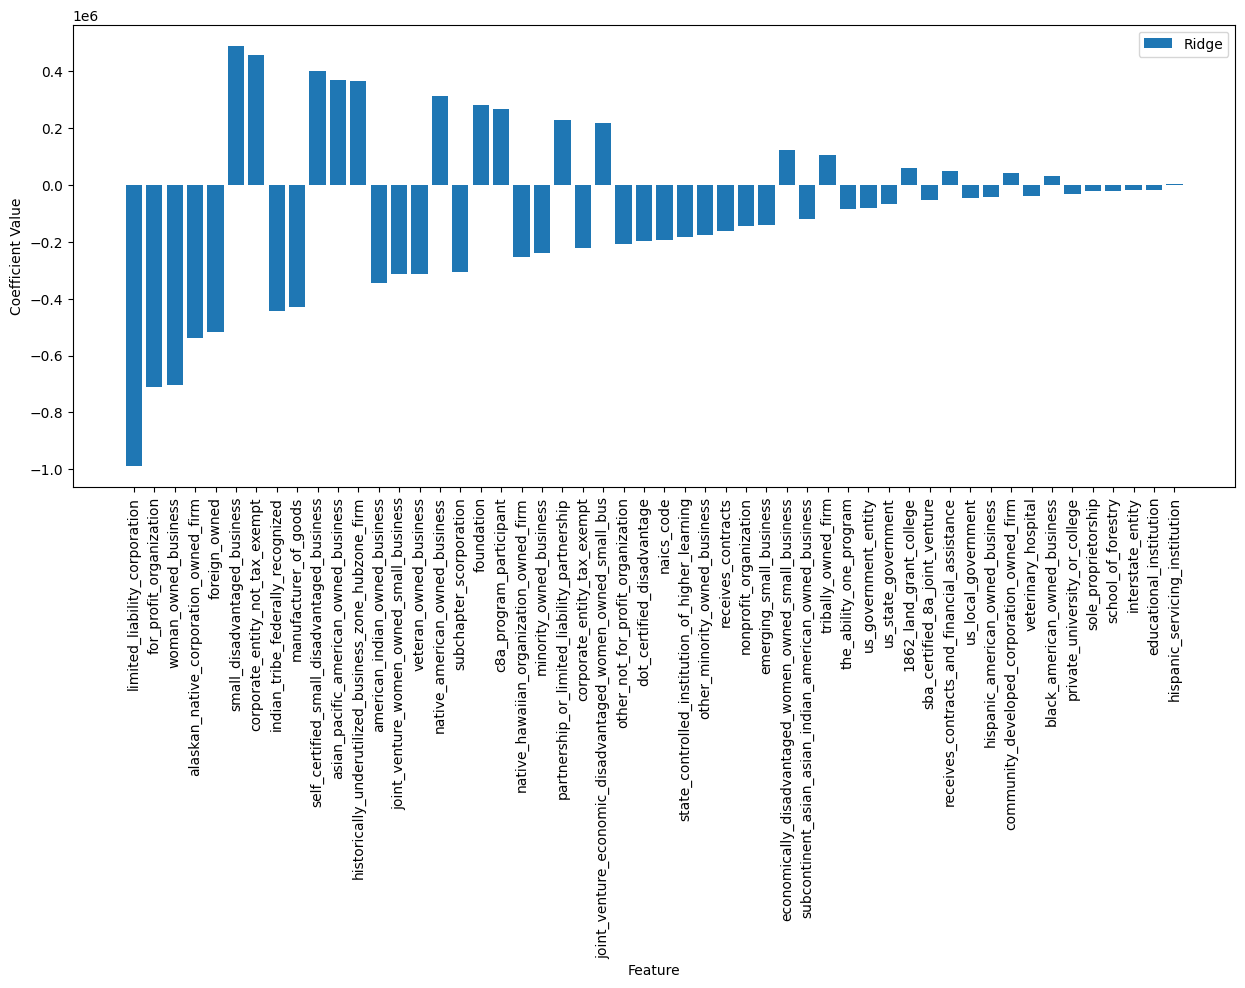

In [14]:
coefficients = Rgrid_search.best_estimator_.coef_[ridge_features_to_keep]
feature_names = np.array(X_train.columns)[ridge_features_to_keep]
sorted_idx = np.argsort(np.abs(coefficients))[::-1]
sorted_feature_names = feature_names[sorted_idx]
sorted_coefficients = coefficients[sorted_idx]

plt.figure(figsize=(15, 6))
plt.bar(sorted_feature_names, sorted_coefficients, label='Ridge')
plt.xticks(rotation=90)
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.legend()
plt.show()

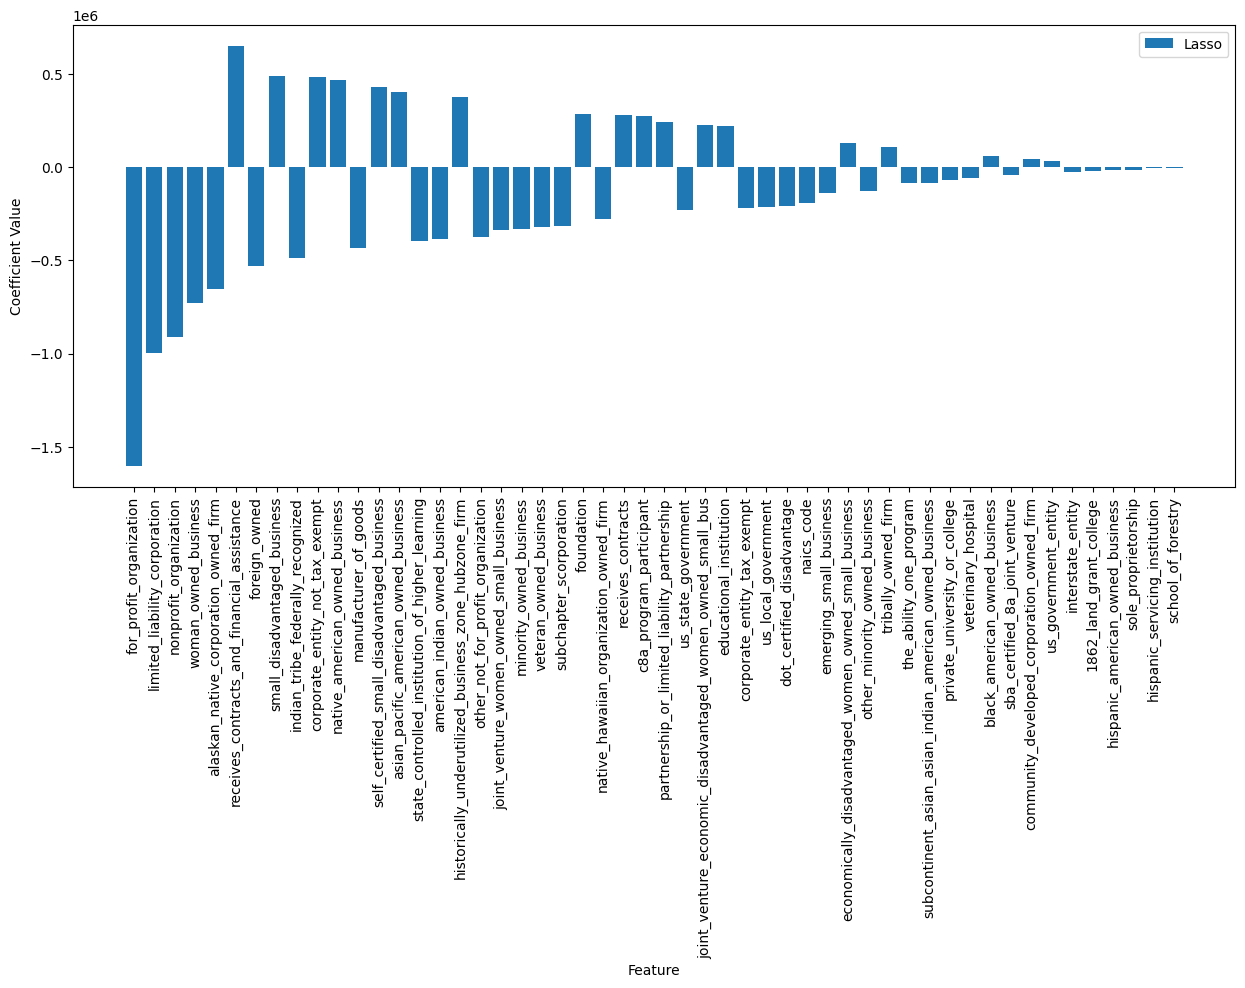

In [15]:
coefficients = Lgrid_search.best_estimator_.coef_[lasso_features_to_keep]
feature_names = np.array(X_train.columns)[lasso_features_to_keep]
sorted_idx = np.argsort(np.abs(coefficients))[::-1]
sorted_feature_names = feature_names[sorted_idx]
sorted_coefficients = coefficients[sorted_idx]

plt.figure(figsize=(15, 6))
plt.bar(sorted_feature_names, sorted_coefficients, label='Lasso')
plt.xticks(rotation=90)
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.legend()
plt.show()